In [1]:
# Download dataset
!gdown 1bqm6-9jHlarb1_NpSXWHuG4pXIHp6fr0

Downloading...
From (original): https://drive.google.com/uc?id=1bqm6-9jHlarb1_NpSXWHuG4pXIHp6fr0
From (redirected): https://drive.google.com/uc?id=1bqm6-9jHlarb1_NpSXWHuG4pXIHp6fr0&confirm=t&uuid=4ae6dcf5-23ad-4602-9059-2719b5cc890b
To: /content/Main_teeth_dataset.zip
100% 90.2M/90.2M [00:00<00:00, 166MB/s]


In [4]:
import zipfile
from pathlib import Path

# Extract the dataset
with zipfile.ZipFile("Main_teeth_dataset.zip", 'r') as zip_file:
    zip_file.extractall("Dataset")

# Define paths
image_dir = Path("Dataset/images")
mask_dir = Path("Dataset/labels")

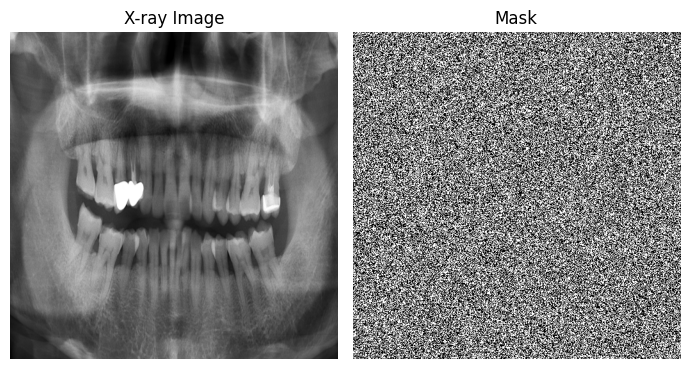

In [17]:
from PIL import Image
import matplotlib.pyplot as plt
import random
image_files = sorted(Path(image_dir).glob("*"))
mask_files = sorted(Path(mask_dir).glob("*"))

# Select a random pair
idx = random.randint(0, len(image_files) - 1)
image_path = image_files[idx]
mask_path = mask_files[idx]

# Open images
image = Image.open(image_path)
mask = Image.open(mask_path)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))

ax1.imshow(image, cmap='gray')
ax1.set_title("X-ray Image")
ax1.axis('off')

ax2.imshow(mask, cmap='gray')
ax2.set_title("Mask")
ax2.axis('off')

plt.tight_layout()
plt.show()

In [18]:
import cv2
import numpy as np
from PIL import Image

def is_noisy_image(image, threshold=60):
    image_np = np.array(image)

    if len(image_np.shape) == 2:
        gray = image_np
    else:
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)

    std_dev = np.std(gray)
    return std_dev > threshold

def get_noisy_masks(mask_dir, threshold=60):
    noisy_masks = []
    for filename in os.listdir(mask_dir):
        path = os.path.join(mask_dir, filename)
        try:
            image = Image.open(path)
            if is_noisy_image(image, threshold=threshold):
                noisy_masks.append(filename)
        except Exception as e:
            print(f"Error processing {filename}: {e}")
    return noisy_masks


mask_dir = 'Dataset/labels'
noisy_masks = get_noisy_masks(mask_dir)
print(len(noisy_masks))

206


In [19]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

import albumentations as A
from albumentations.pytorch import ToTensorV2

split_ratio = 0.8

class TeethSegmentationDataset(Dataset):
    def __init__(self, image_dir: str, mask_dir: str, transform: A.Compose, dataset_type: str = 'Train', noisy_masks: list = None):
        """
        Args:
            image_dir (str): Directory path containing input images.
            mask_dir (str): Directory path containing corresponding segmentation masks.
            transform (callable): Optional transformation to be applied to both the image and the mask. Use A.Compose. Use ToTensorV2()
            dataset_type (str, optional): Type of dataset, e.g., 'Train' or 'Test'. Defaults to 'Train'.
            noisy_masks (list, optional): Provide a list of names for images you want to be excluded from dataset
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.dataset_type = dataset_type
        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)
        if noisy_masks:
            self.images = [img for img in self.images if img not in noisy_masks]
            self.masks = [mask for mask in self.masks if mask not in noisy_masks]
        number_of_samples = len(self.images)

        if dataset_type == 'Train':
            self.images = self.images[:int(number_of_samples*split_ratio)]
            self.masks = self.masks[:int(number_of_samples*split_ratio)]
        elif dataset_type == 'Test':
            self.images = self.images[int(number_of_samples*split_ratio):]
            self.masks = self.masks[int(number_of_samples*split_ratio):]



    def __len__(self) -> int:
        """
        Returns:
            int: The total number of image-mask pairs in the designated dataset split.
        """
        return len(self.images)


    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            index (int): Index of the image-mask pair to retrieve.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: A tuple containing the image and its corresponding one-hot encoded mask.
                - image (torch.Tensor): Transformed image tensor.
                - mask (torch.Tensor): Mask tensor for segmentation.
        """
        image_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])
        image = np.array(Image.open(image_path).convert("L"))
        mask = np.array(Image.open(mask_path).convert("L"))
        transformed = self.transform(image=image, mask=mask)
        image = transformed['image']
        mask = transformed['mask']
        binary_mask = mask.unsqueeze(2)>0
        binary_mask = binary_mask.permute(2, 0, 1).float()

        return image, binary_mask

In [21]:
######################augmenters######################
############DO Augmentation if needed#################
######################################################
augmenter = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.2),
    A.Normalize(mean=(0.485,), std=(0.229,), max_pixel_value=255.0),
    ToTensorV2(),
])

test_augmenter = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485,), std=(0.229,), max_pixel_value=255.0),
    ToTensorV2(),
])


train_dataset = TeethSegmentationDataset(
    image_dir='Dataset/images',
    mask_dir='Dataset/labels',
    transform=augmenter,
    dataset_type='Train',
    noisy_masks=noisy_masks,
)


test_dataset = TeethSegmentationDataset(
    image_dir='Dataset/images',
    mask_dir='Dataset/labels',
    transform=test_augmenter,
    dataset_type='Test',
    noisy_masks=noisy_masks
)

In [22]:
from torch.utils.data import DataLoader


batch_size=2
num_workers=0

dataloaders = {
  'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
  'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
}

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 317
Test dataset size: 80


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class res_conv(nn.Module):
    '''
    A residual convolutional block that applies two convolutional layers, each followed by:
    convolution (ks=3, padding=1) -> BatchNorm2d -> LeakyReLU (inplace=True) -> Dropout (0.1), and then adds the input to the output for a residual connection.

    Args:
        input_channels (int): Number of input channels (e.g., 1 for grayscale image).
        output_channels (int): Number of output channels after convolution.
        down (bool, optional): If True, the network can be used for downsampling. Default is True.

    Output:
        x2 (Tensor): Output tensor after passing through two convolutions with a residual connection.
    '''
    def __init__(self, input_channels, output_channels, down=True):
        super(res_conv, self).__init__()
        self.conv1 = nn.Sequential( # NOTE
            nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.1)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(0.1)
        )
        self.residual = nn.Sequential() # NOTE
        if input_channels != output_channels:
            self.residual = nn.Conv2d(input_channels, output_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        return x2 + self.residual(x)

class start_conv(nn.Module):
    '''
    Initial convolution block that applies a residual convolutional block with the specified input and output channels.

    Args:
        input_channels (int): Number of input channels (e.g., 1 for grayscale image).
        output_channels (int): Number of output channels.

    Output:
        x (Tensor): Output tensor after passing through the residual convolutional block.
    '''
    def __init__(self, input_channels, output_channels):
        super(start_conv, self).__init__()
        self.conv = res_conv(input_channels, output_channels)

    def forward(self, x):
        x = self.conv(x)
        return x

class down_conv(nn.Module):
    '''
    Downsampling convolutional block that applies max-pooling (stride = 2) followed by a residual convolutional block.

    Args:
        input_channels (int): Number of input channels.
        output_channels (int): Number of output channels after downsampling.

    Output:
        x (Tensor): Output tensor after max-pooling and residual convolution.
    '''
    def __init__(self, input_channels, output_channels):
        super(down_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),  # MaxPooling operation for downsampling
            res_conv(input_channels, output_channels),
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(up_conv, self).__init__()
        # self.up = nn.ConvTranspose2d(input_channels // 2, input_channels // 2, kernel_size=2, stride=2)  # Upsampling layer
        # self.conv = res_conv(input_channels, output_channels)
        decoder_channels = input_channels - output_channels
        self.up = nn.ConvTranspose2d(decoder_channels, decoder_channels, kernel_size=2, stride=2) # NOTE Needed to change
        self.conv = res_conv(input_channels, output_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)  # Apply upsampling
        # Padding to match dimensions after upsampling
        diff1 = x2.shape[2] - x1.shape[2]
        diff2 = x2.shape[3] - x1.shape[3]
        x1 = F.pad(x1, pad=(diff1 // 2, diff1 - diff1 // 2, diff2 // 2, diff2 - diff2 // 2))
        x = torch.cat([x2, x1], dim=1)  # Concatenate along the channel dimension
        x = self.conv(x)
        return x

class stop_conv(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(stop_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=1)  # 1x1 convolution
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class Model(nn.Module):
    '''
    A full model that applies the start convolution block, down-sampling, up-sampling, and final stop convolution block.

    The architecture follows a U-Net style where the input passes through:
    start_conv(1->64) -> down_conv (4 times (64->512)) -> up_conv (4 times) -> stop_conv.

    Args:
        None (this is a default constructor for the model).

    Output:
        out (Tensor): Final output tensor with shape [batch_size, 1, height, width].
    '''
    def __init__(self):
        super(Model, self).__init__()
        self.inc = start_conv(1, 64)

        self.down1 = down_conv(64, 128)
        self.down2 = down_conv(128, 256)
        self.down3 = down_conv(256, 512)
        self.down4 = down_conv(512, 1024)

        self.up1 = up_conv(1024 + 512, 512)
        self.up2 = up_conv(512 + 256, 256)
        self.up3 = up_conv(256 + 128, 128)
        self.up4 = up_conv(128 + 64, 64)

        self.outc = stop_conv(64, 1)

    def forward(self, x):
        xin = self.inc(x)

        xd1 = self.down1(xin)
        xd2 = self.down2(xd1)
        xd3 = self.down3(xd2)
        xd4 = self.down4(xd3)

        xu1 = self.up1(xd4, xd3)
        xu2 = self.up2(xu1, xd2)
        xu3 = self.up3(xu2, xd1)
        xu4 = self.up4(xu3, xin)

        out = self.outc(xu4)
        return out

In [24]:
device = 'cuda'

model = Model().to(device)

image = next(iter(dataloaders['train']))[0].to(device)
out = model(image)
print(image.shape)
print(out.shape)
assert image.shape == (batch_size, 1, 512, 512), "You shouldn't change the size of the image"
assert out.shape == (batch_size, 1, 512, 512), "The output of your model do not have correct dimensions"

torch.Size([2, 1, 512, 512])
torch.Size([2, 1, 512, 512])


In [25]:
def dice_score(pred: torch.Tensor, target_mask: torch.Tensor, epsilon: float = 1e-6) -> float:
    """
    Computes the Dice score between the predicted and target segmentation masks.

    Args:
        pred (torch.Tensor): The predicted mask tensor, with values in range [0, 1].
        target_one_target_maskhot (torch.Tensor): The ground truth mask.
        epsilon (float, optional): A small value to avoid division by zero. Defaults to 1e-6.

    Returns:
        float: The Dice score, a similarity metric between 0 and 1.
    """
    pred = pred>0
    pred_flat = pred.contiguous().view(pred.shape[0], pred.shape[1], -1)
    target_flat = target_mask.contiguous().view(target_mask.shape[0], target_mask.shape[1], -1)
    intersection = (pred_flat * target_flat).sum(dim=-1)
    union = pred_flat.sum(dim=-1) + target_flat.sum(dim=-1)
    dice = (2. * intersection + epsilon) / (union + epsilon)
    dice_mean = dice.mean(dim=1)
    return dice_mean.mean()

In [26]:
import torch.optim as optim

# use proper loss function and optimizer
# class BCEDiceLoss(nn.Module):
#     def __init__(self, bce_weight=0.5):
#         super(BCEDiceLoss, self).__init__()
#         self.bce = nn.BCEWithLogitsLoss()
#         self.bce_weight = bce_weight

#     def forward(self, pred, target):
#         pred = pred.squeeze(1)
#         target = target.squeeze(1)
#         bce_loss = self.bce(pred, target)
#         pred_sigmoid = torch.sigmoid(pred).unsqueeze(1)
#         dice = dice_score(pred_sigmoid, target.unsqueeze(1))
#         return self.bce_weight * bce_loss + (1 - self.bce_weight) * (1 - dice)

class DiceLoss(nn.Module):
    def __init__(self, smooth: float=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred) # Convert logits to probs
        pred = pred.view(pred.size(0), -1)
        target = target.view(target.size(0), -1)

        intersection = (pred * target).sum(dim=1)
        union = pred.sum(dim=1) + target.sum(dim=1)

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1 - dice

        return dice_loss.mean()


criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [27]:
import matplotlib.pyplot as plt


def visualize_mask(inputs: torch.Tensor, masks: torch.Tensor, outputs: torch.Tensor):
    sample_index = 0
    channel = 0
    print(f'Dice score is {dice_score(outputs[sample_index:sample_index+1,channel:channel+1],masks[sample_index:sample_index+1,channel:channel+1])}')

    inputs_np = inputs.cpu().numpy()
    masks_np = masks.cpu().numpy()
    outputs_np = outputs.detach().cpu().numpy()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(inputs_np[sample_index].transpose(1, 2, 0), cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masks_np[sample_index, channel], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(outputs_np[sample_index, channel]>0, cmap='gray')
    plt.title("Model Output Mask")
    plt.axis('off')

    plt.show()

Epoch 0/49
----------
train Loss: 0.4073
Dice score is 0.2497197985649109


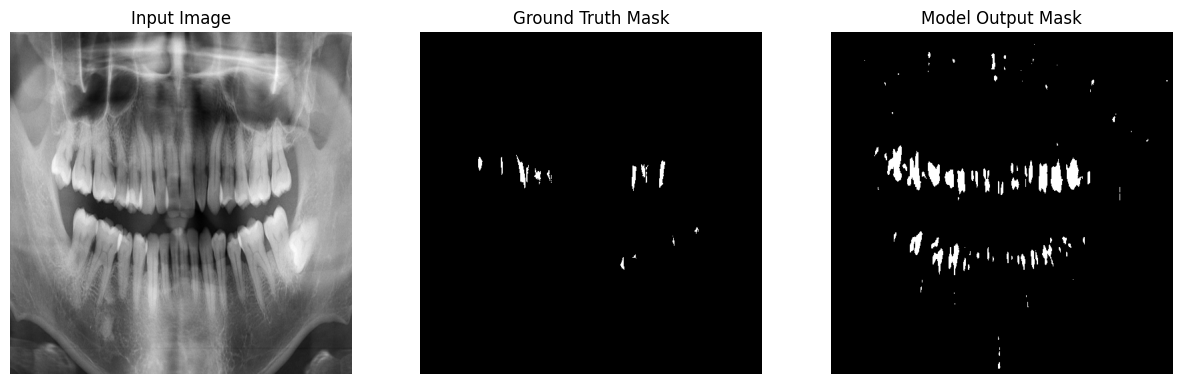

test Loss: 0.4093
Dice score: 0.20878534018993378
Epoch 1/49
----------
train Loss: 0.3377
Dice score is 0.5789284706115723


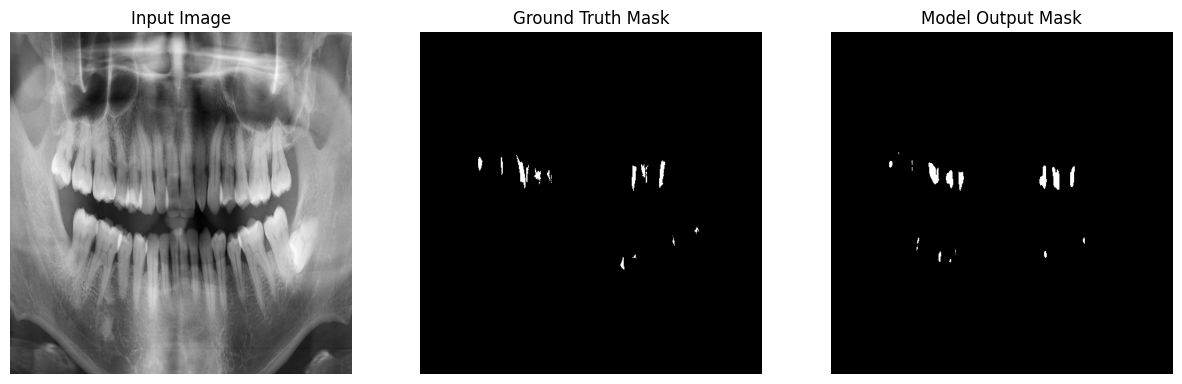

test Loss: 0.3713
Dice score: 0.2570219039916992
Epoch 2/49
----------
train Loss: 0.3174
Dice score is 0.5429248213768005


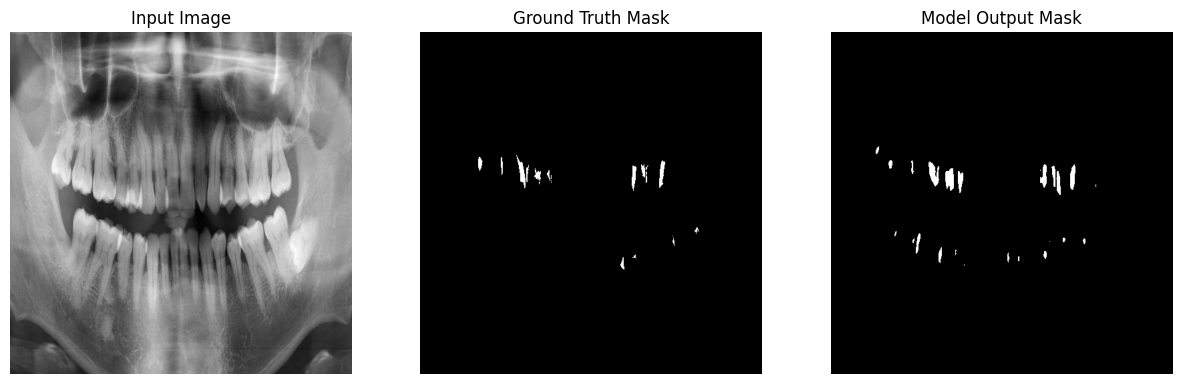

test Loss: 0.3355
Dice score: 0.3297300636768341
Epoch 3/49
----------
train Loss: 0.3052
Dice score is 0.4954034686088562


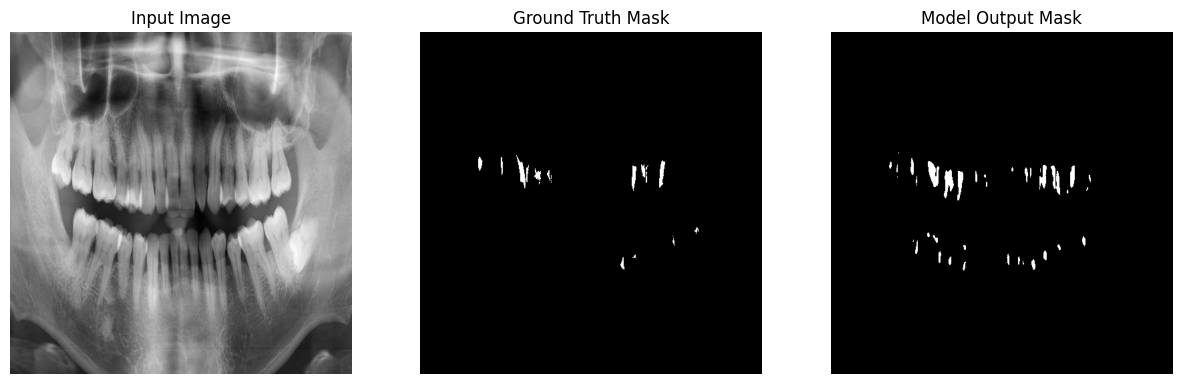

test Loss: 0.3221
Dice score: 0.3575877249240875
Epoch 4/49
----------
train Loss: 0.2935
Dice score is 0.6151571273803711


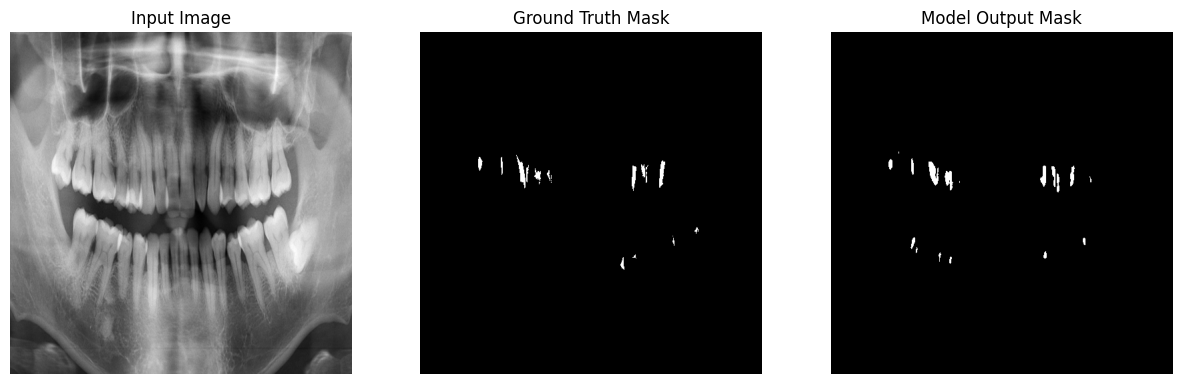

test Loss: 0.3156
Dice score: 0.36935728788375854
Epoch 5/49
----------
train Loss: 0.2813
Dice score is 0.6302222013473511


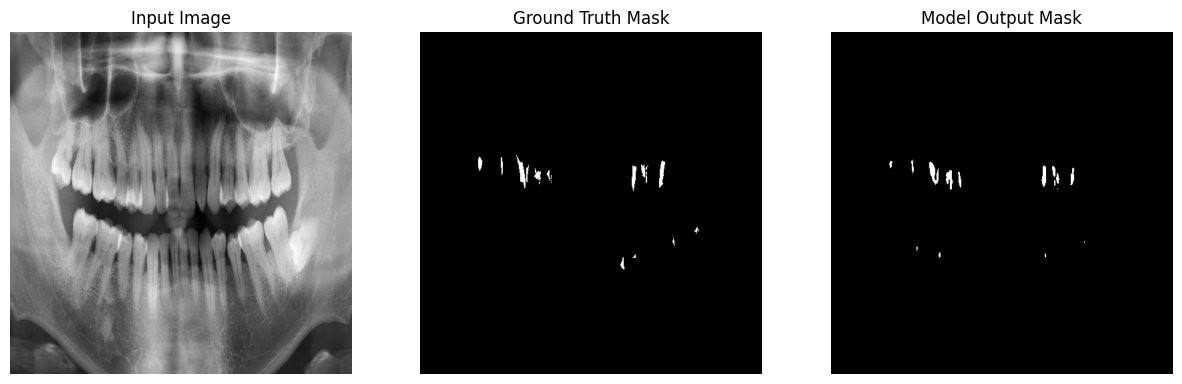

test Loss: 0.3157
Dice score: 0.3688114881515503
Epoch 6/49
----------
train Loss: 0.2739
Dice score is 0.6500851511955261


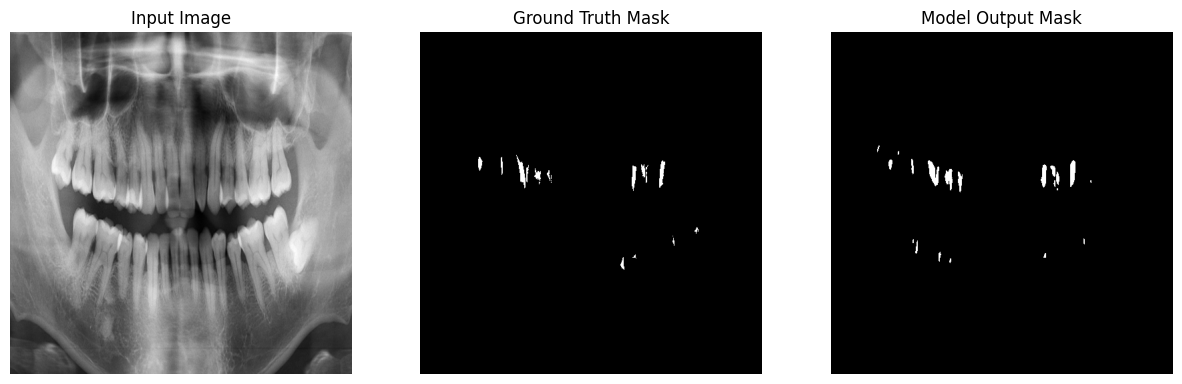

test Loss: 0.3071
Dice score: 0.3859477639198303
Epoch 7/49
----------
train Loss: 0.2697
Dice score is 0.6193805932998657


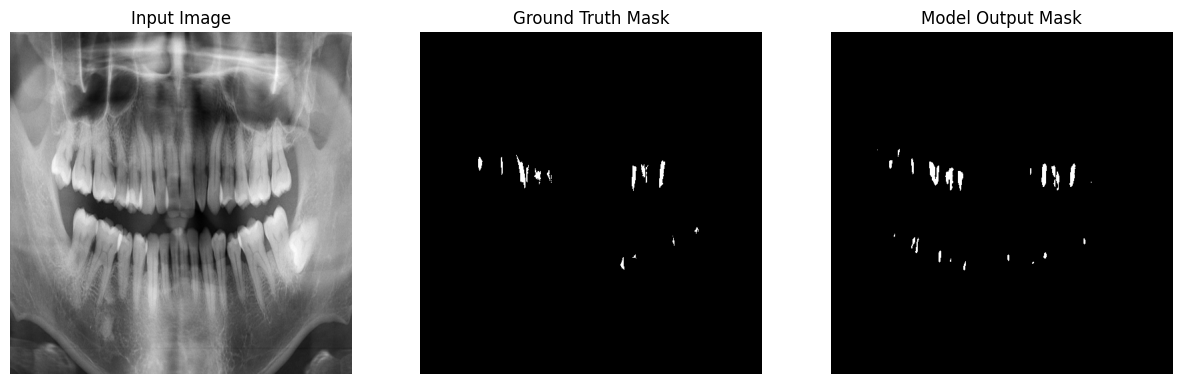

test Loss: 0.2769
Dice score: 0.4469868242740631
Epoch 8/49
----------
train Loss: 0.2618
Dice score is 0.6079938411712646


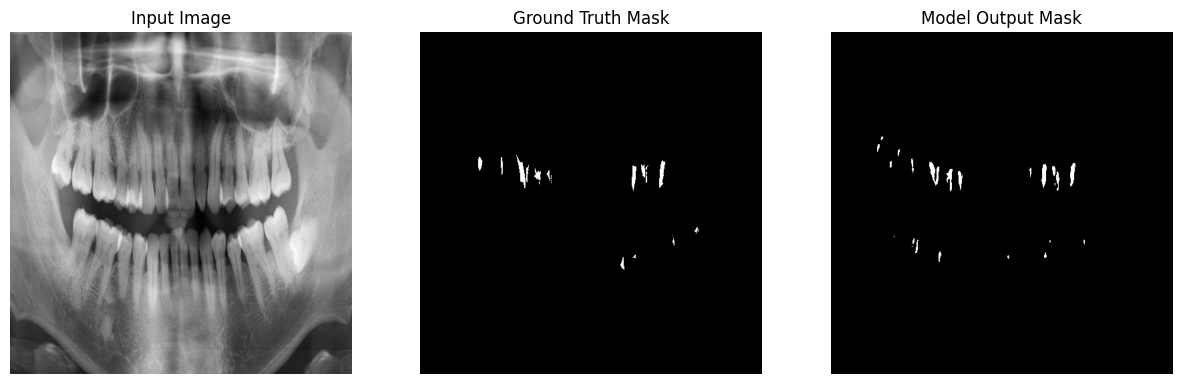

test Loss: 0.2796
Dice score: 0.44143104553222656
Epoch 9/49
----------
train Loss: 0.2601
Dice score is 0.5179709196090698


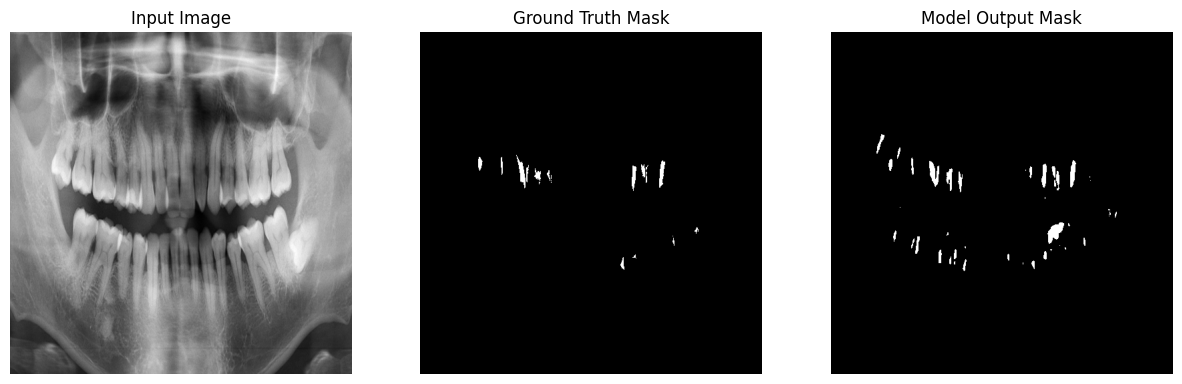

test Loss: 0.2790
Dice score: 0.44472283124923706
Epoch 10/49
----------
train Loss: 0.2570
Dice score is 0.6037025451660156


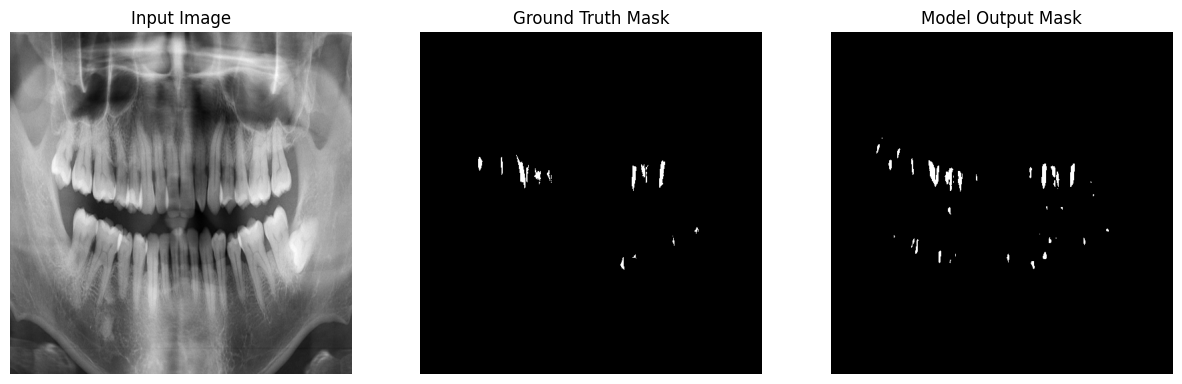

test Loss: 0.2664
Dice score: 0.46959027647972107
Epoch 11/49
----------
train Loss: 0.2514
Dice score is 0.5749783515930176


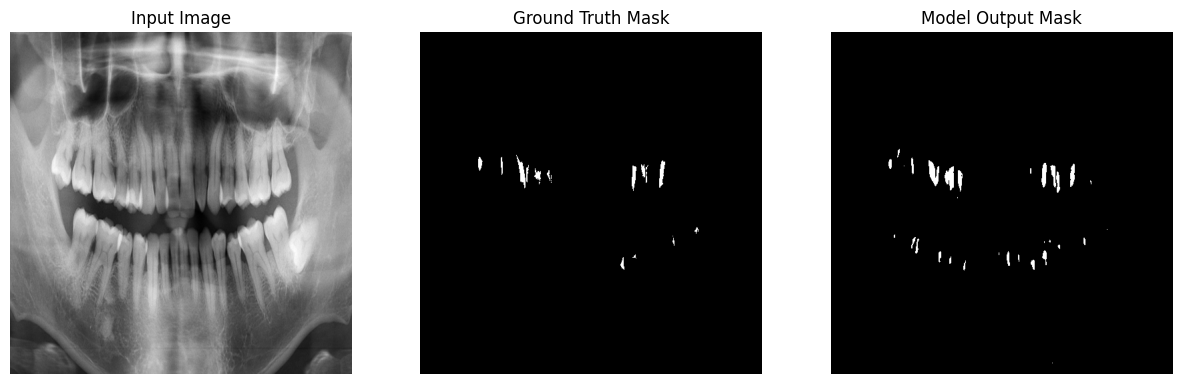

test Loss: 0.2752
Dice score: 0.45090824365615845
Epoch 12/49
----------
train Loss: 0.2499
Dice score is 0.6204225420951843


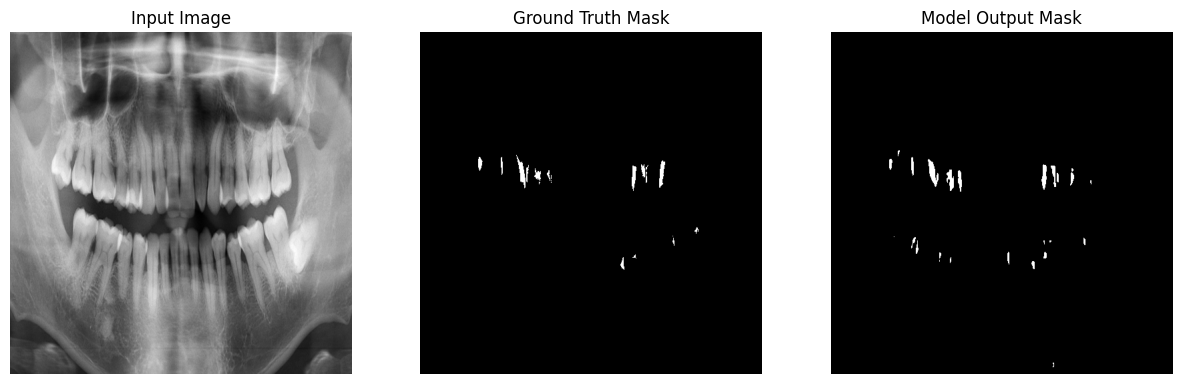

test Loss: 0.2807
Dice score: 0.4392664432525635
Epoch 13/49
----------
train Loss: 0.2498
Dice score is 0.5802395343780518


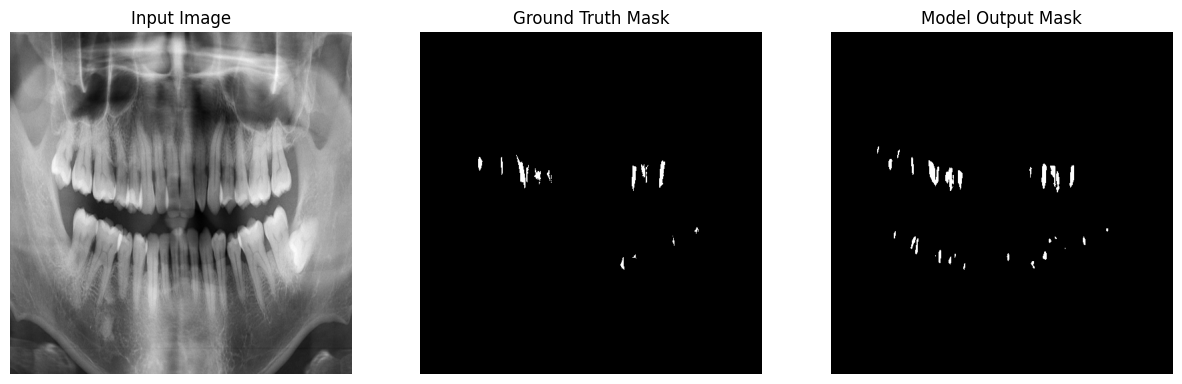

test Loss: 0.2679
Dice score: 0.4660663604736328
Epoch 14/49
----------
train Loss: 0.2424
Dice score is 0.6630474328994751


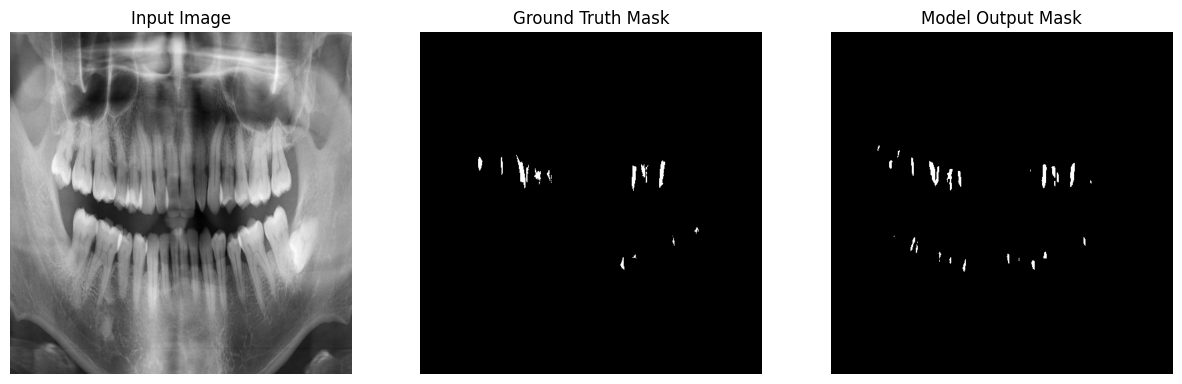

test Loss: 0.2761
Dice score: 0.4483482837677002
Epoch 15/49
----------
train Loss: 0.2393
Dice score is 0.6662049889564514


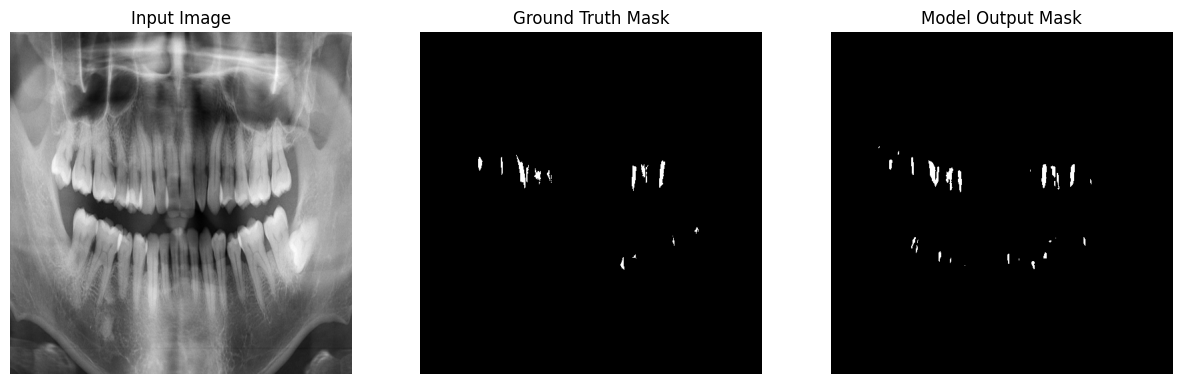

test Loss: 0.2578
Dice score: 0.4854356646537781
Epoch 16/49
----------
train Loss: 0.2353
Dice score is 0.6437956094741821


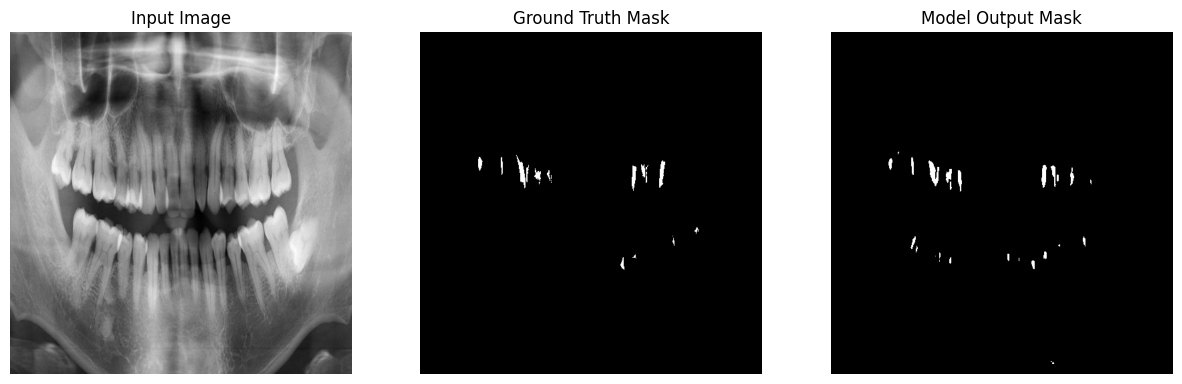

test Loss: 0.2619
Dice score: 0.4771505296230316
Epoch 17/49
----------
train Loss: 0.2323
Dice score is 0.5754174590110779


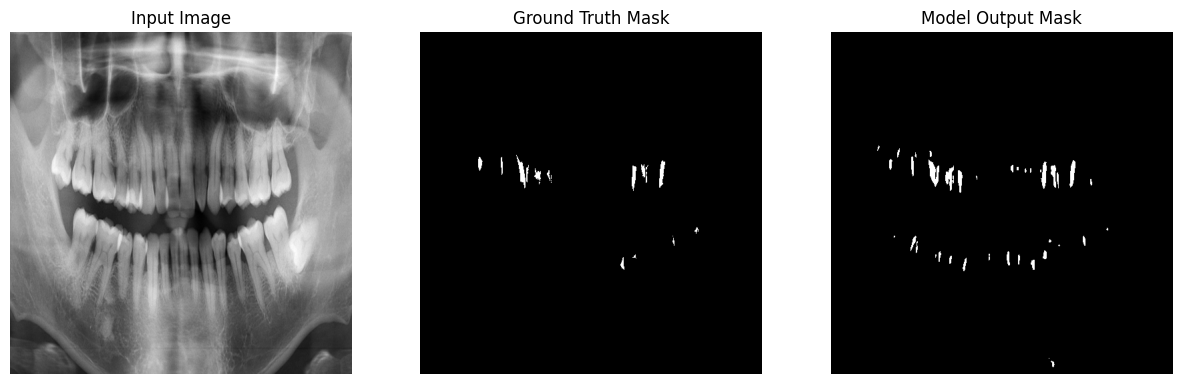

test Loss: 0.2473
Dice score: 0.5072920322418213
Epoch 18/49
----------
train Loss: 0.2315
Dice score is 0.6164340972900391


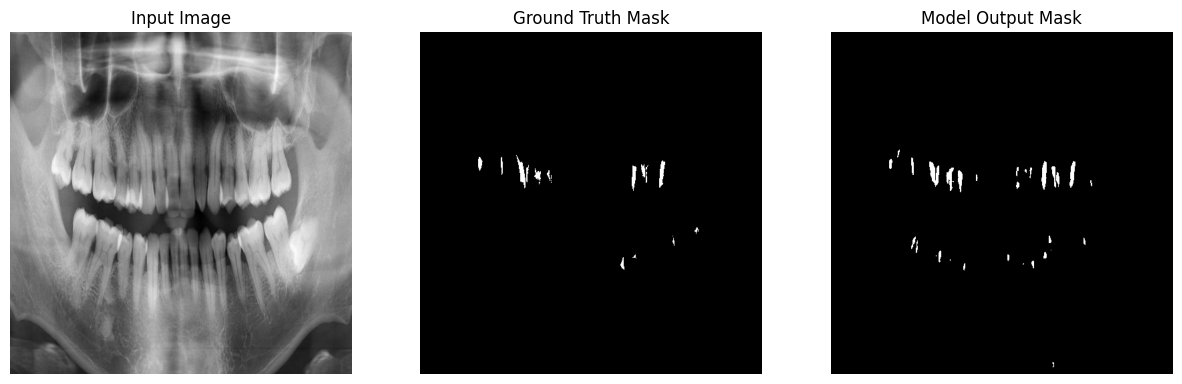

test Loss: 0.2561
Dice score: 0.488271564245224
Epoch 19/49
----------
train Loss: 0.2328
Dice score is 0.6478976011276245


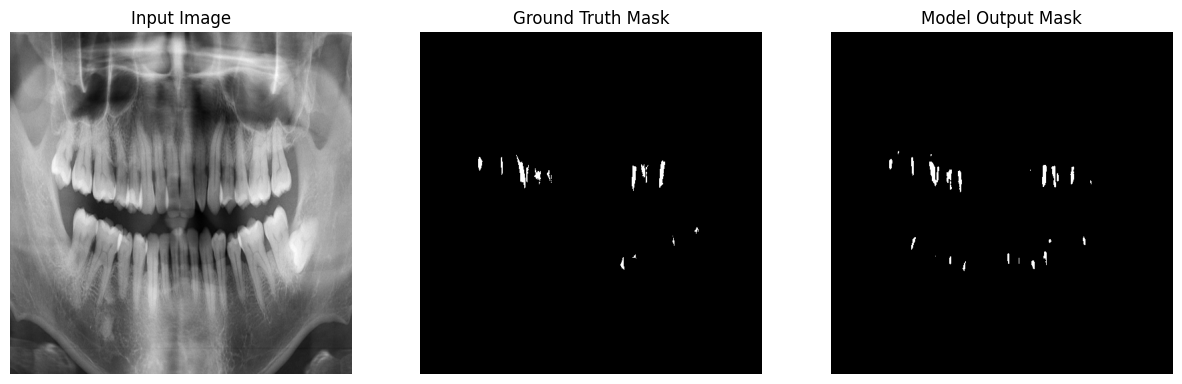

test Loss: 0.2603
Dice score: 0.4797803461551666
Epoch 20/49
----------
train Loss: 0.2295
Dice score is 0.5821880102157593


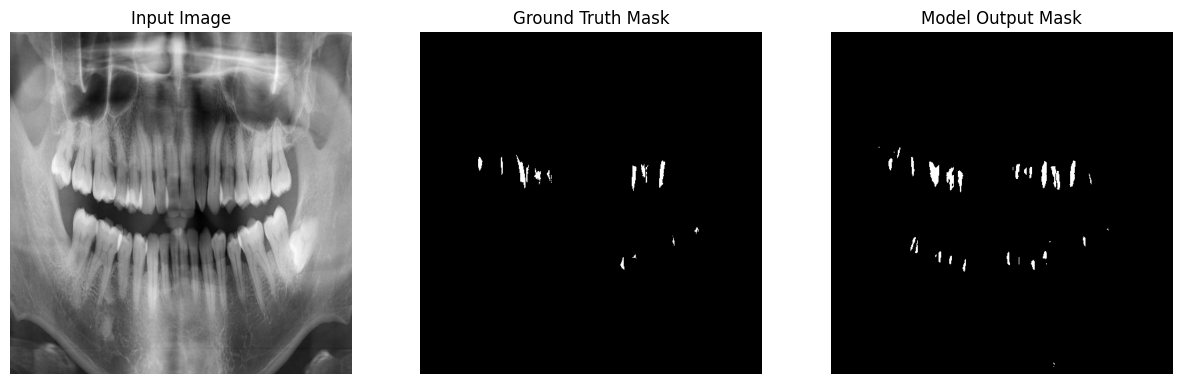

test Loss: 0.2489
Dice score: 0.5034155249595642
Epoch 21/49
----------
train Loss: 0.2258
Dice score is 0.6605991721153259


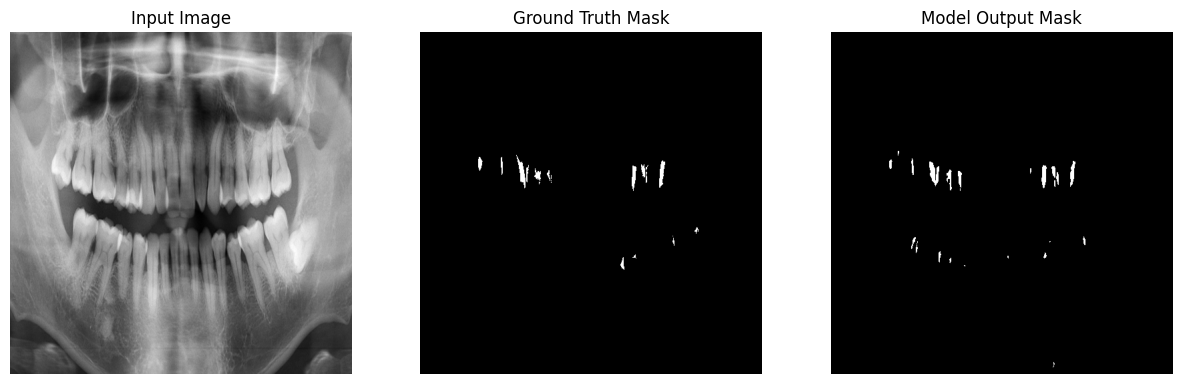

test Loss: 0.2558
Dice score: 0.4892042279243469
Epoch 22/49
----------
train Loss: 0.2238
Dice score is 0.6268460750579834


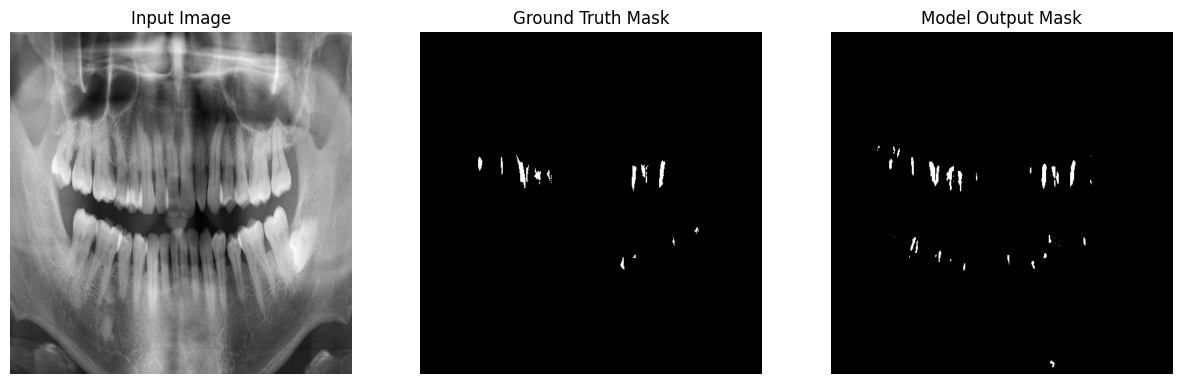

test Loss: 0.2450
Dice score: 0.5113805532455444
Epoch 23/49
----------
train Loss: 0.2250
Dice score is 0.6666666865348816


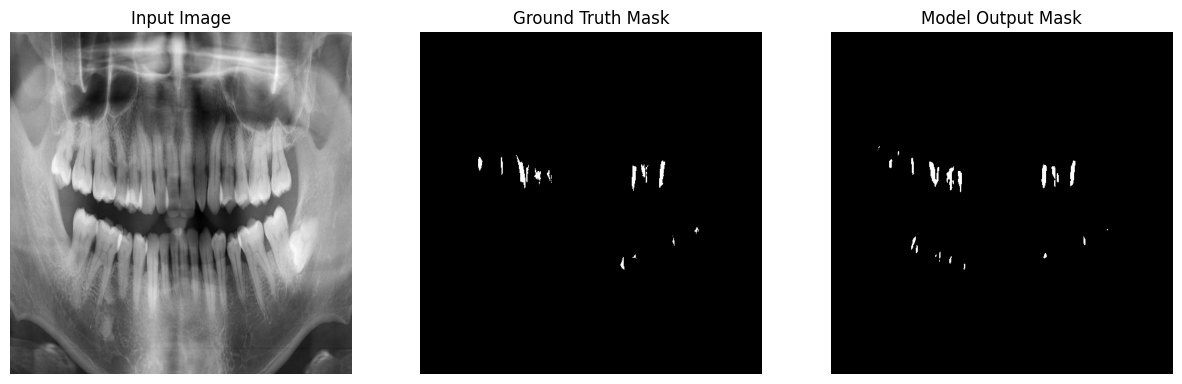

test Loss: 0.2657
Dice score: 0.4690702557563782
Epoch 24/49
----------
train Loss: 0.2200
Dice score is 0.6894514560699463


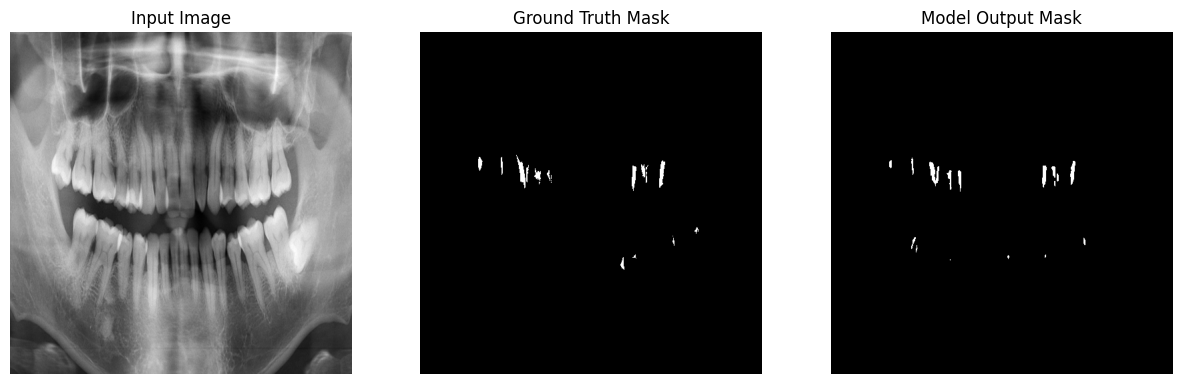

test Loss: 0.2653
Dice score: 0.4701877534389496
Epoch 25/49
----------
train Loss: 0.2190
Dice score is 0.645380437374115


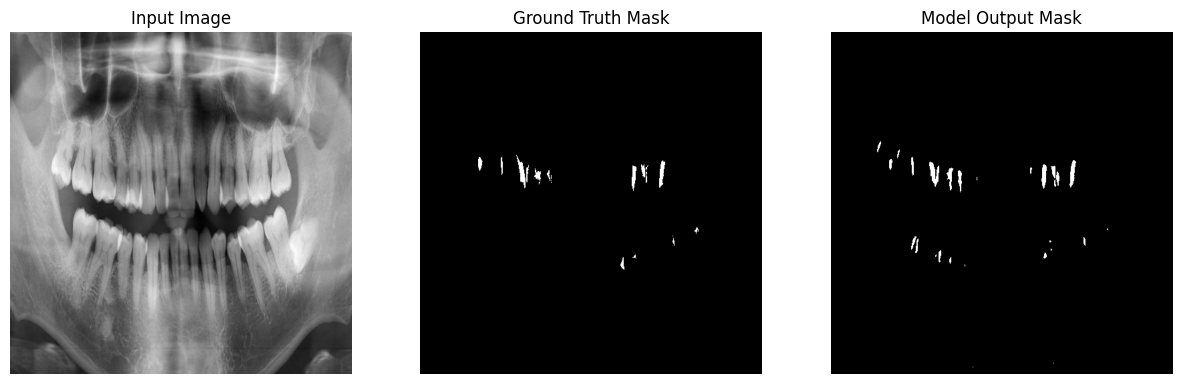

test Loss: 0.2537
Dice score: 0.4937790334224701
Epoch 26/49
----------
train Loss: 0.2176
Dice score is 0.671544075012207


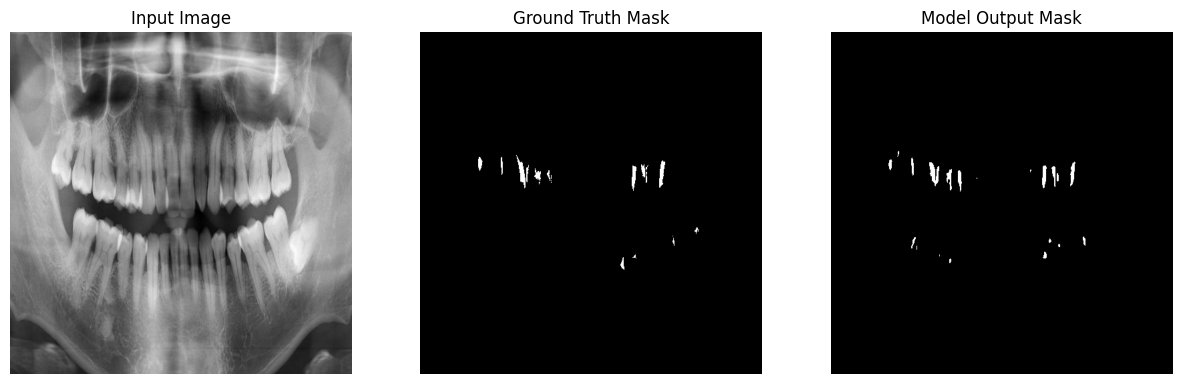

test Loss: 0.2495
Dice score: 0.5015564560890198
Epoch 27/49
----------
train Loss: 0.2148
Dice score is 0.6449275612831116


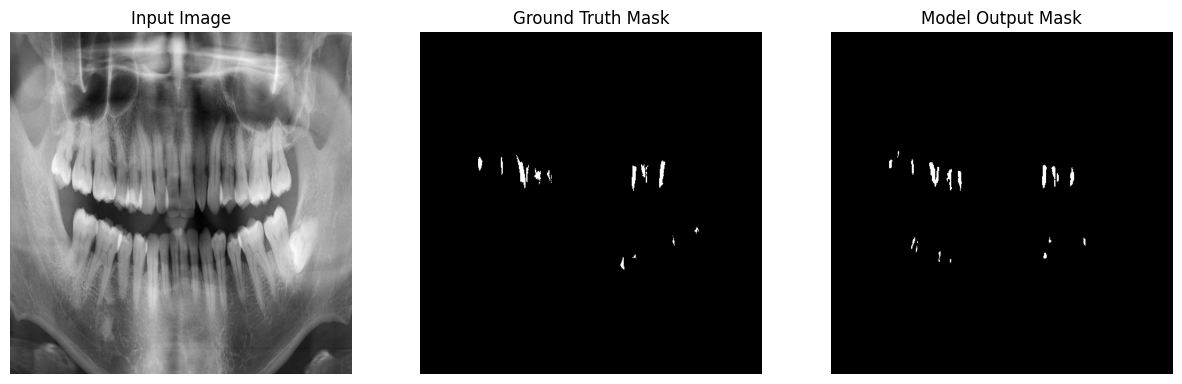

test Loss: 0.2607
Dice score: 0.4789621829986572
Epoch 28/49
----------
train Loss: 0.2155
Dice score is 0.6228225827217102


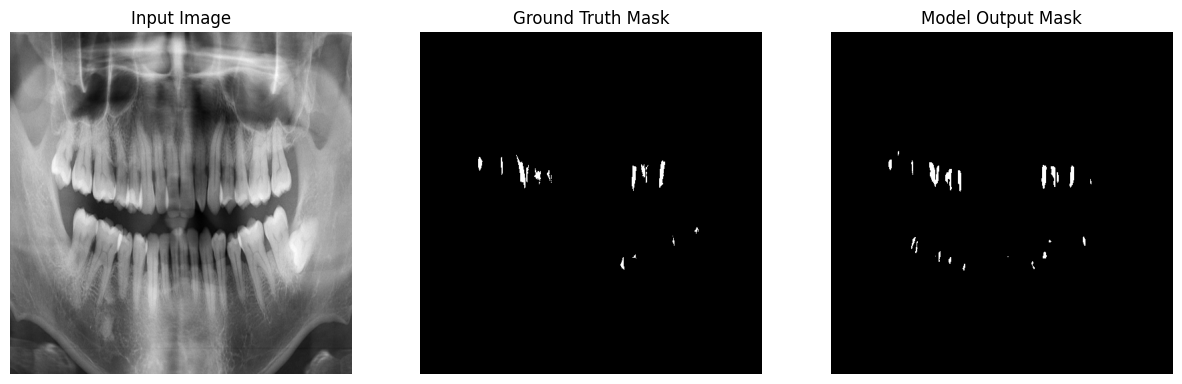

test Loss: 0.2637
Dice score: 0.47314453125
Epoch 29/49
----------
train Loss: 0.2116
Dice score is 0.6585014462471008


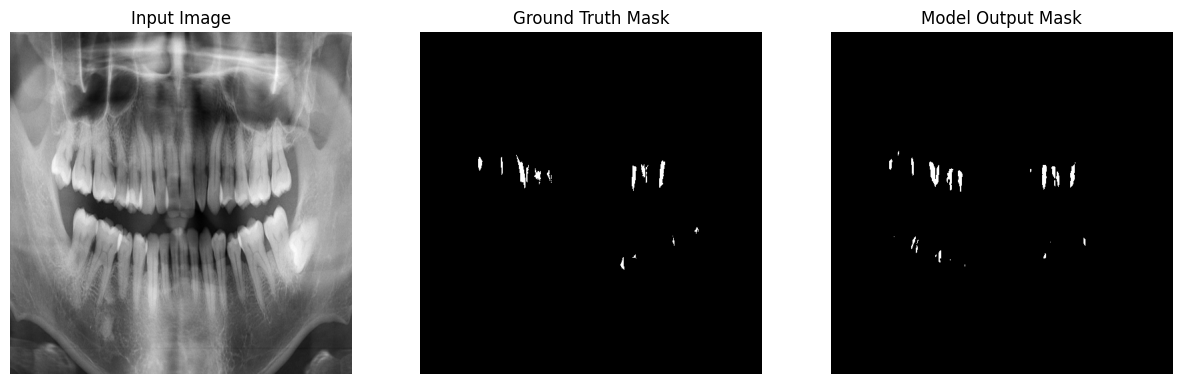

test Loss: 0.2474
Dice score: 0.5058844089508057
Epoch 30/49
----------
train Loss: 0.2089
Dice score is 0.6096938848495483


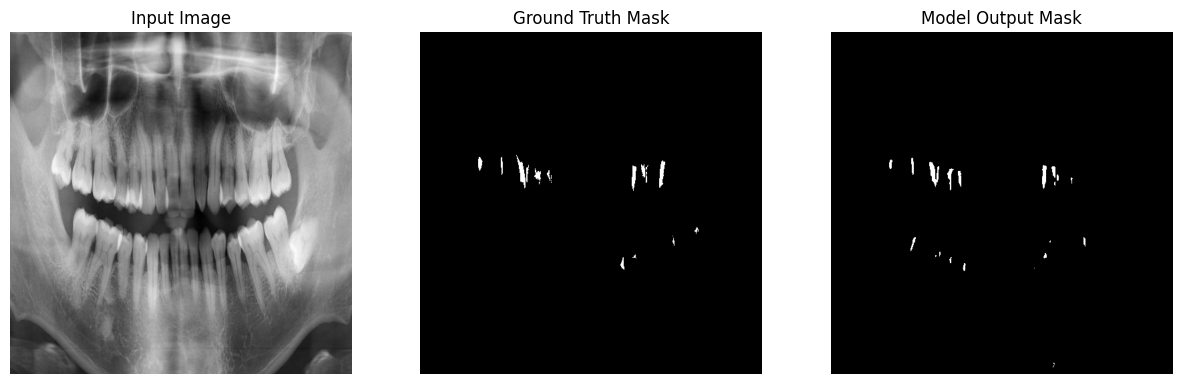

test Loss: 0.2661
Dice score: 0.4680822491645813
Epoch 31/49
----------
train Loss: 0.2099
Dice score is 0.6600804924964905


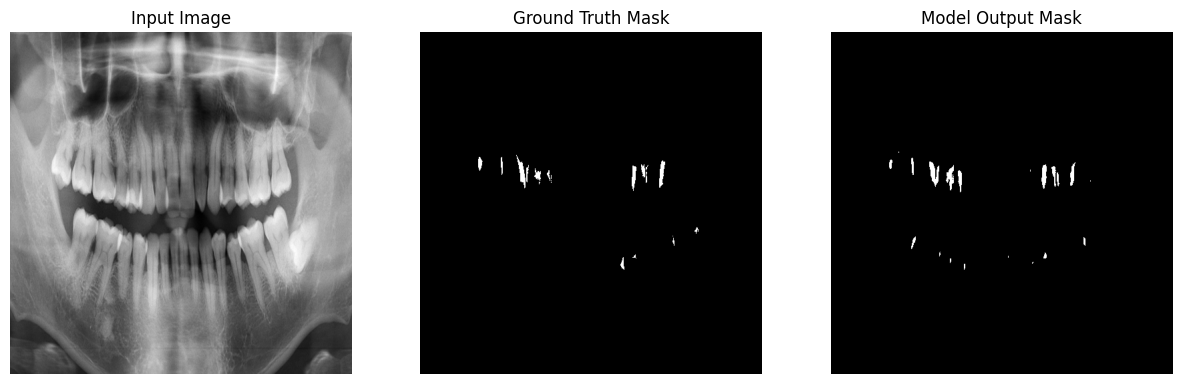

test Loss: 0.2502
Dice score: 0.5000506639480591
Epoch 32/49
----------
train Loss: 0.2049
Dice score is 0.5947521924972534


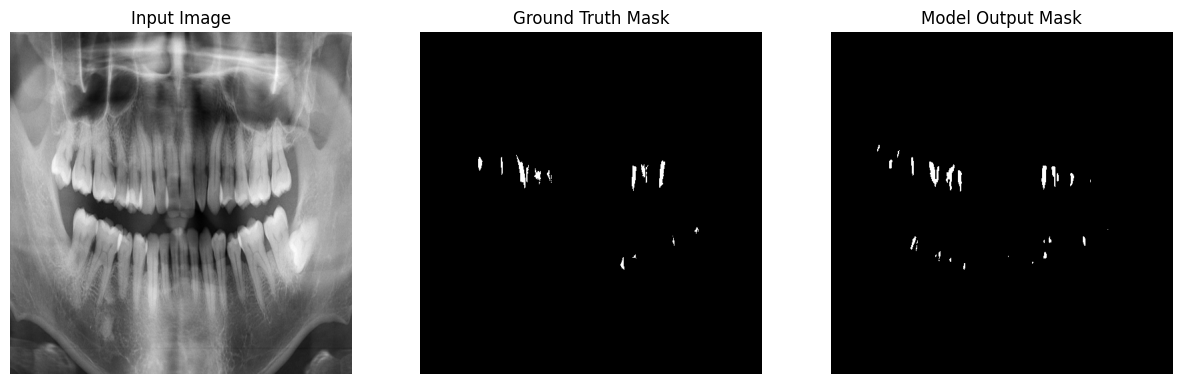

test Loss: 0.2537
Dice score: 0.49310559034347534
Epoch 33/49
----------
train Loss: 0.2029
Dice score is 0.6314243674278259


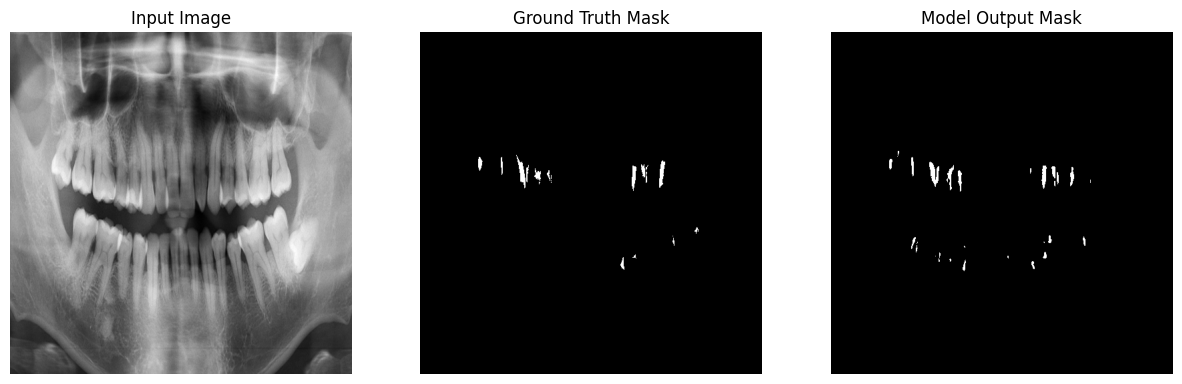

test Loss: 0.2496
Dice score: 0.5014334917068481
Epoch 34/49
----------
train Loss: 0.2048
Dice score is 0.6346570253372192


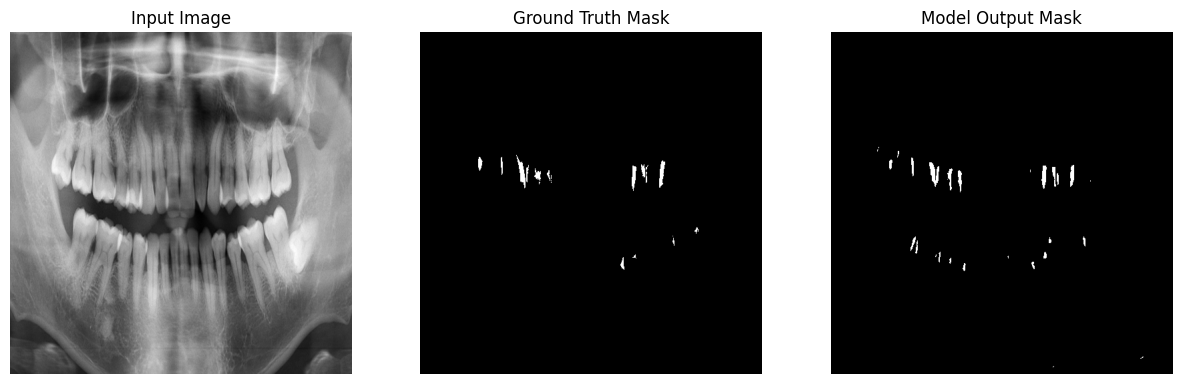

test Loss: 0.2478
Dice score: 0.5051575303077698
Epoch 35/49
----------
train Loss: 0.1997
Dice score is 0.6807855367660522


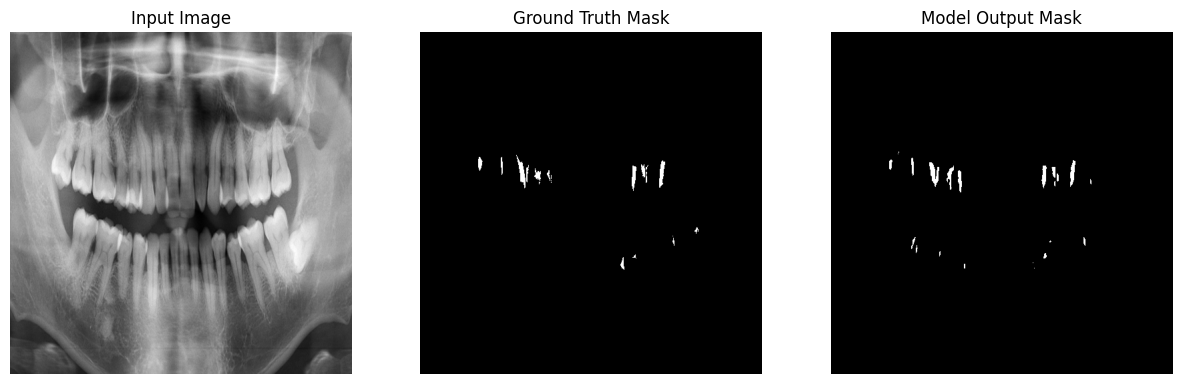

test Loss: 0.2530
Dice score: 0.4944029748439789
Epoch 36/49
----------
train Loss: 0.2018
Dice score is 0.646952748298645


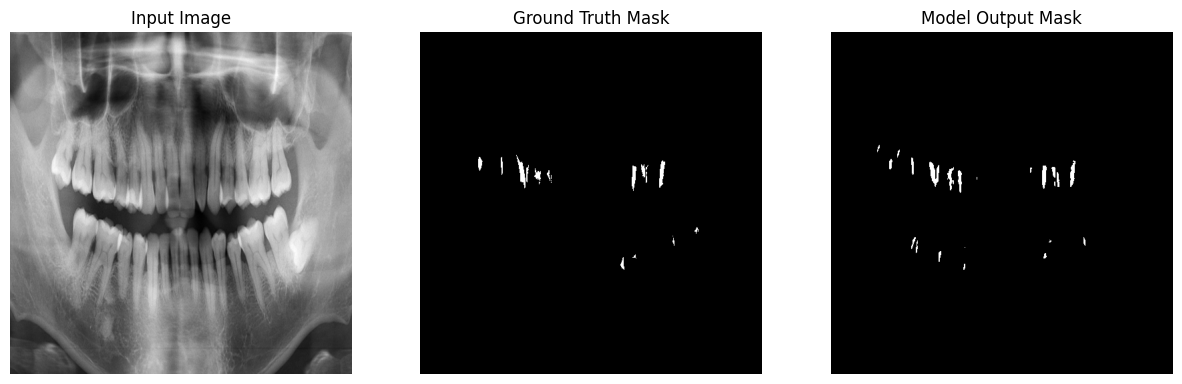

test Loss: 0.2485
Dice score: 0.5034640431404114
Epoch 37/49
----------
train Loss: 0.2001
Dice score is 0.6625129580497742


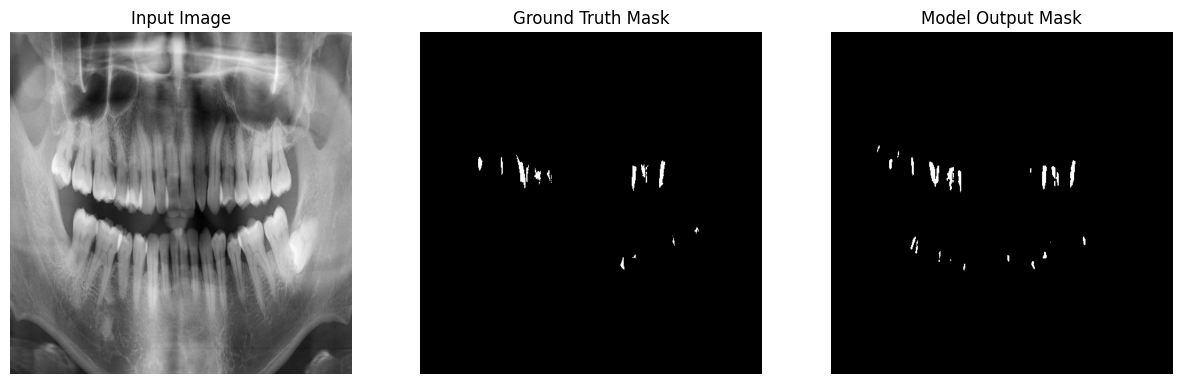

test Loss: 0.2422
Dice score: 0.516065776348114
Epoch 38/49
----------
train Loss: 0.1979
Dice score is 0.6537901163101196


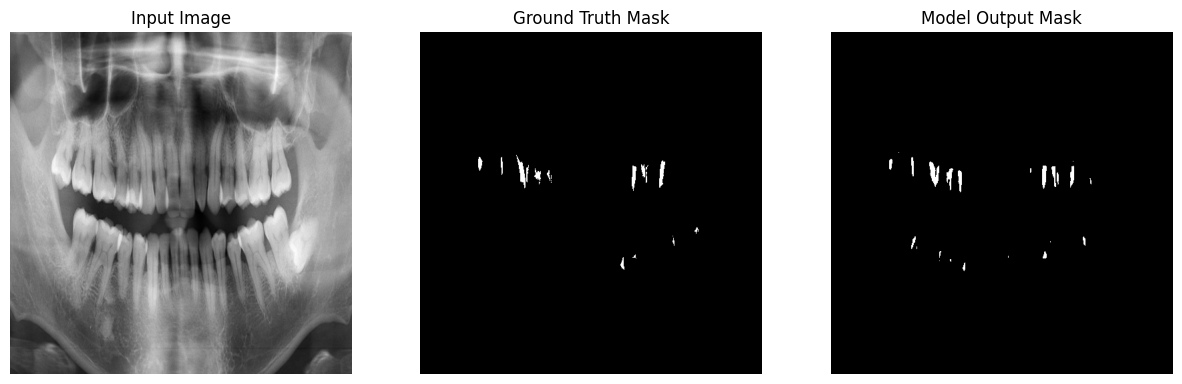

test Loss: 0.2408
Dice score: 0.5190999507904053
Epoch 39/49
----------
train Loss: 0.1978
Dice score is 0.6624113321304321


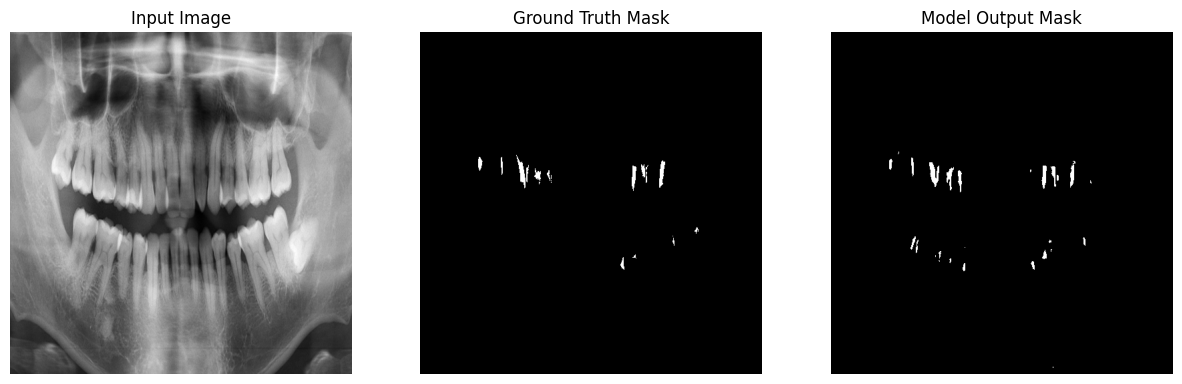

test Loss: 0.2456
Dice score: 0.5098325610160828
Epoch 40/49
----------
train Loss: 0.1937
Dice score is 0.6925613880157471


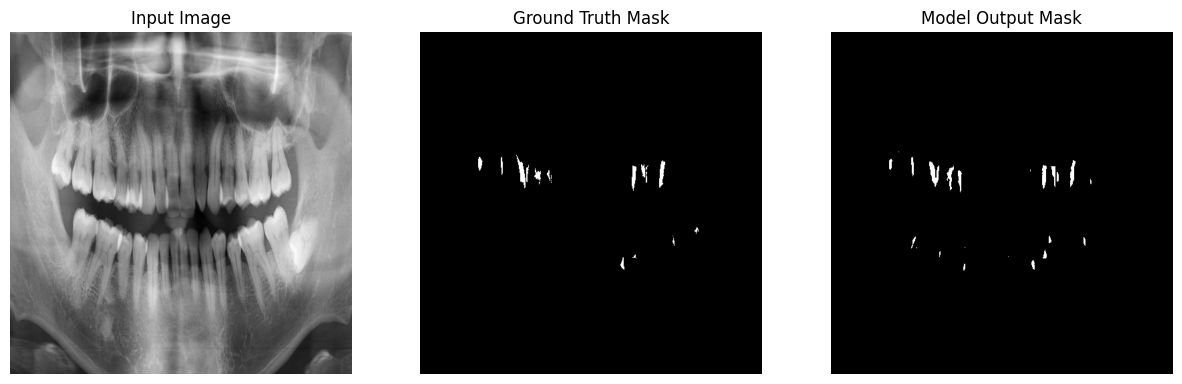

test Loss: 0.2484
Dice score: 0.5032915472984314
Epoch 41/49
----------
train Loss: 0.1943
Dice score is 0.6942889094352722


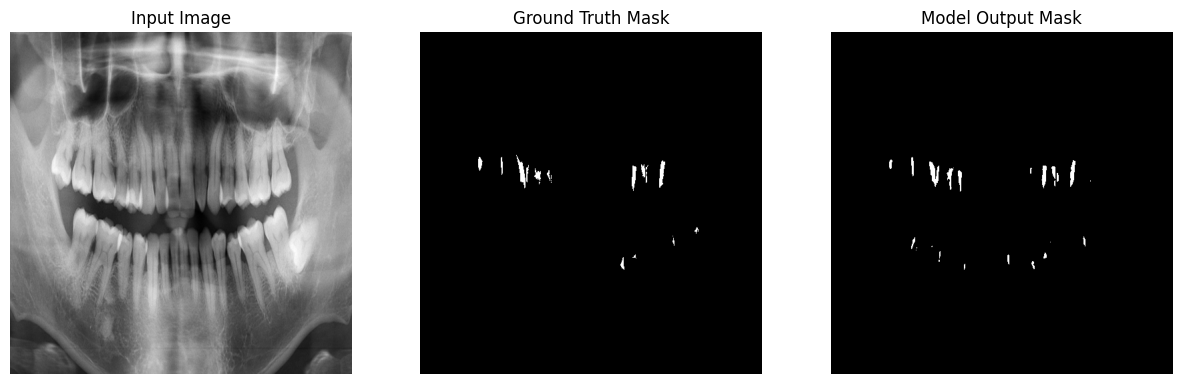

test Loss: 0.2455
Dice score: 0.5095261335372925
Epoch 42/49
----------
train Loss: 0.1901
Dice score is 0.6591976881027222


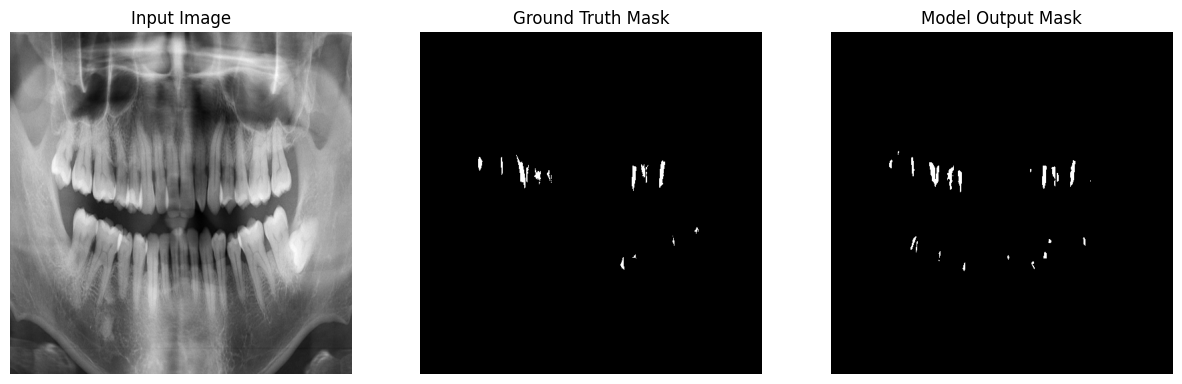

test Loss: 0.2442
Dice score: 0.511815071105957
Epoch 43/49
----------
train Loss: 0.1893
Dice score is 0.6669619083404541


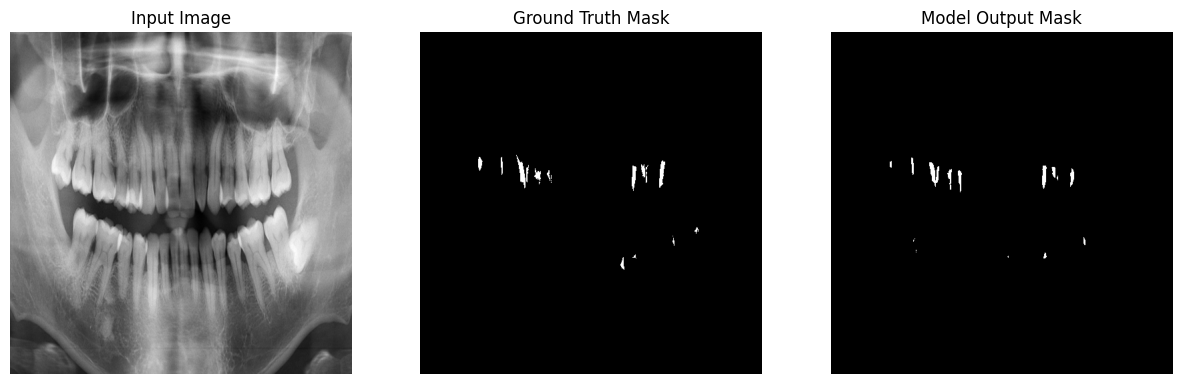

test Loss: 0.2623
Dice score: 0.47567838430404663
Epoch 44/49
----------
train Loss: 0.1908
Dice score is 0.6562855839729309


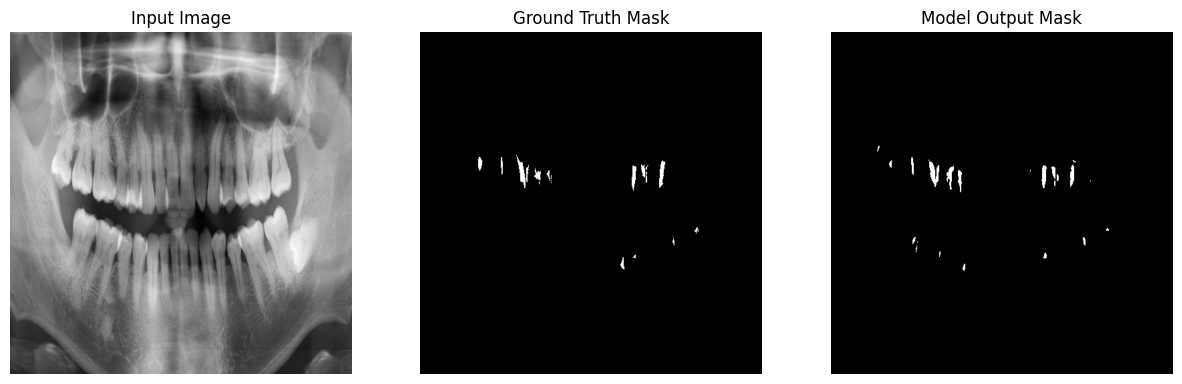

test Loss: 0.2474
Dice score: 0.5060290694236755
Epoch 45/49
----------
train Loss: 0.1873
Dice score is 0.6518936157226562


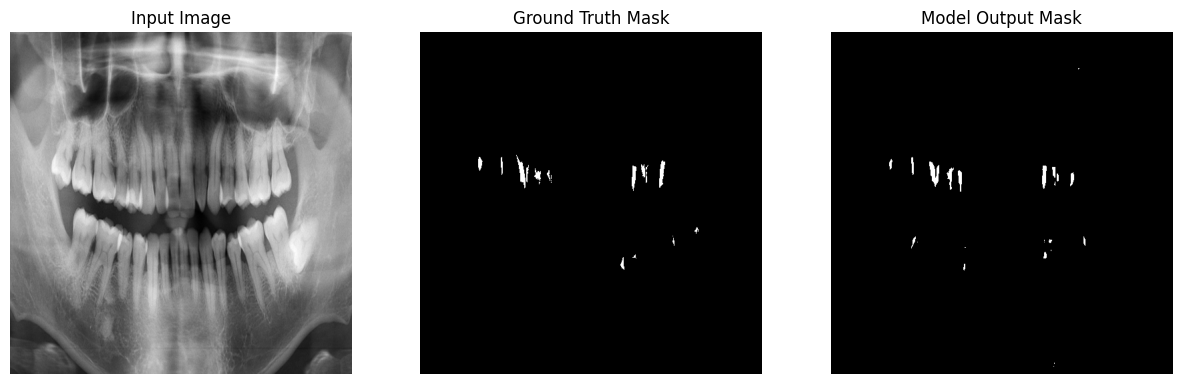

test Loss: 0.2454
Dice score: 0.5094928741455078
Epoch 46/49
----------
train Loss: 0.1865
Dice score is 0.6584831476211548


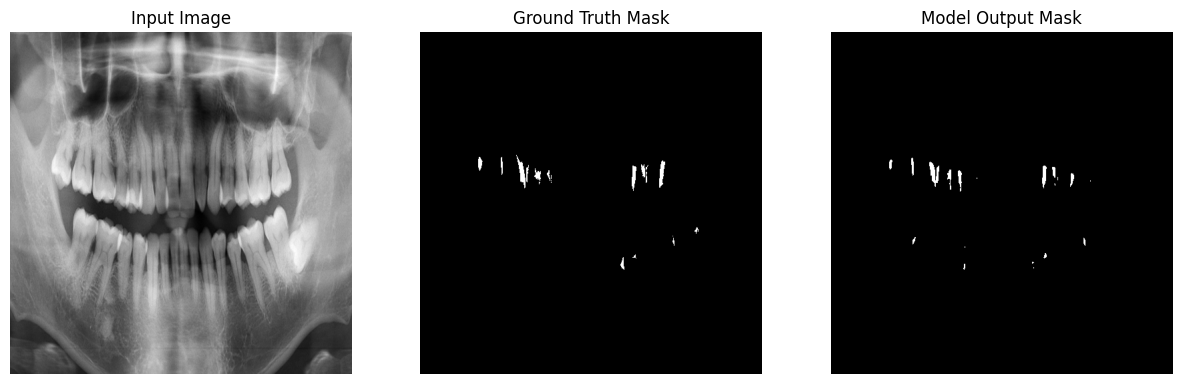

test Loss: 0.2660
Dice score: 0.4678882956504822
Epoch 47/49
----------
train Loss: 0.1836
Dice score is 0.638824462890625


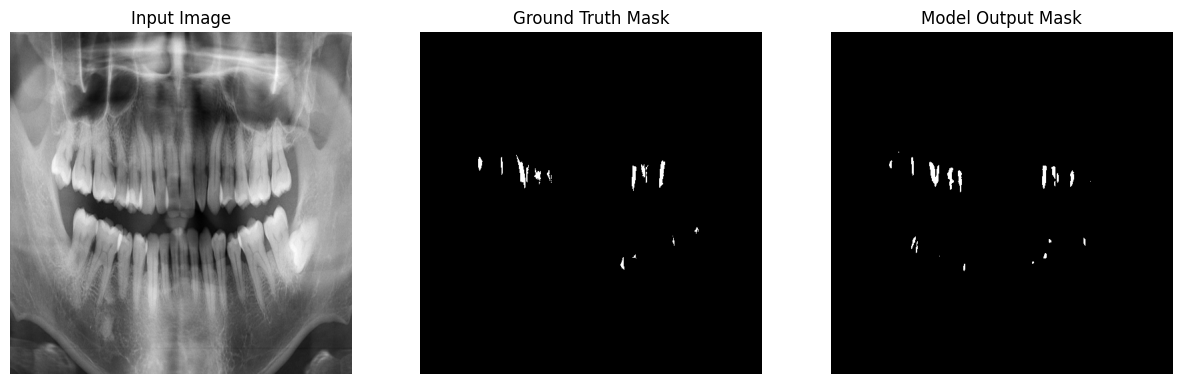

test Loss: 0.2487
Dice score: 0.5027526617050171
Epoch 48/49
----------
train Loss: 0.1841
Dice score is 0.6227360367774963


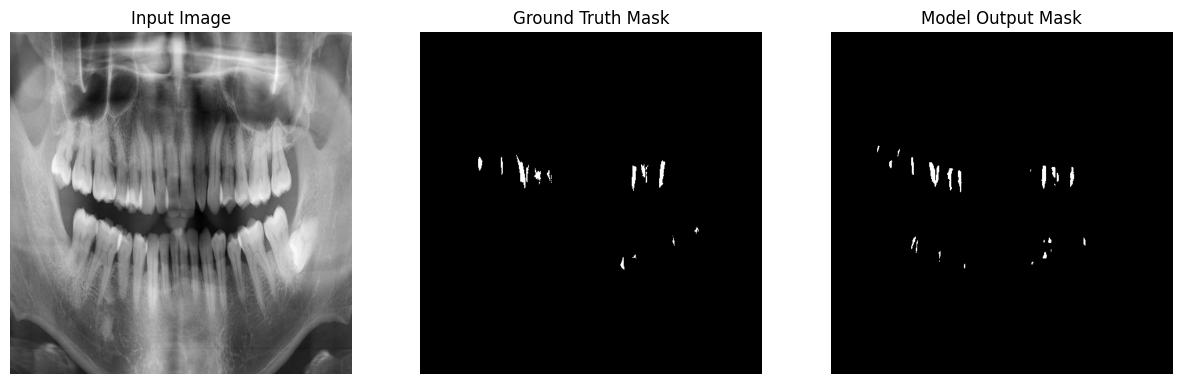

test Loss: 0.2613
Dice score: 0.4773968756198883
Epoch 49/49
----------
train Loss: 0.1817
Dice score is 0.6725949645042419


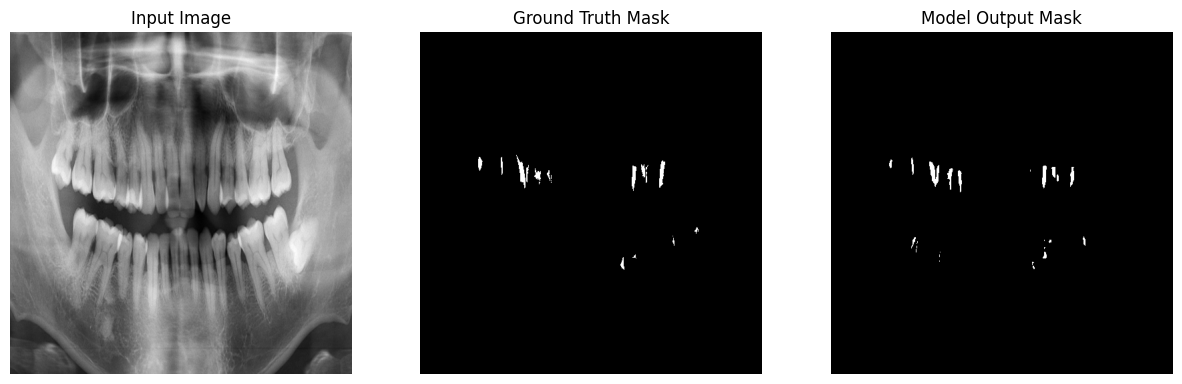

test Loss: 0.2530
Dice score: 0.4941476881504059
Training complete in 109m 12s


In [29]:
import torch
import time
import matplotlib.pyplot as plt
import torchvision
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

model = model.to(device)

def train_model(
    model: nn.Module,
    dataloaders: dict[str, DataLoader],
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    num_epochs: int = 50
) -> nn.Module:
    """
    Trains the model over a specified number of epochs using the given data loaders,
    criterion (loss function), and optimizer.

    Args:
        model (nn.Module): The PyTorch model to be trained.
        dataloaders (dict[str, DataLoader]): A dictionary containing 'train' and 'test' data loaders.
        criterion (nn.Module): The loss function to be used for training.
        optimizer (torch.optim.Optimizer): The optimizer used to adjust model parameters.
        num_epochs (int, optional): Number of epochs for training. Defaults to 25.

    Returns:
        nn.Module: The trained model.
    """
    since = time.time()

    train_losses = []
    test_losses = []
    dice_scores_epoch = []

    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

    for epoch in range(num_epochs):
        dice_scores = []
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0

            for inputs, masks in dataloaders[phase]:
                inputs = inputs.to(device)
                masks = masks.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    loss = criterion(outputs, masks)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    else:
                        dice_scores.append(dice_score(outputs, masks))

                running_loss += loss.item() # NOTE * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                test_losses.append(epoch_loss)
                dice_scores_epoch.append(torch.tensor(dice_scores).mean().item())

                visualize_mask(inputs, masks, outputs)

            print(f'{phase} Loss: {epoch_loss:.4f}')
            if phase == 'test':
                print(f'Dice score: {torch.tensor(dice_scores).mean()}')

        scheduler.step()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model

model = train_model(model, dataloaders, criterion, optimizer)